## NLP Project "Hate Speech Detection using Transformers (DL)" 

Group Name: individually

Name: Kristina Kaliagina

Email: kalyagina.kristina@gmail.com

Country: Russia

College/Company: Graduated from the University “Higher School of Economics”

Specialization: NLP

###### Problem description 

The task of the project is to classify tweets from Twitter, namely, it is necessary to create a model that will help determine whether a particular tweet belongs to such a type of speech as hate speech. Hate Speech, in simple terms, is offensive language directed at individuals or groups based on their affiliation, interests, and characteristics, such as their religion, nationality, race, color, origin, gender, or other identity factor.

The task is quite difficult because of the inherent complexity of natural language constructs - different forms of hatred, different types of goals, different ways of representing the same meaning.


## Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import joblib
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
import warnings 
warnings.filterwarnings("ignore")

## Download data

In [2]:
data=pd.read_csv('./for_model.csv')

In [3]:
data=data[['label', 'clean_tweet']]
data

,label,clean_tweet
0,1,via
1,1,mma fans losses matter mma fans rr lost twic...
2,1,thatas really shitty headline change it
3,1,boob camron diaz naked pics
4,1,makes ask yourself i anybody god oh thank god
...,...,...
55001,0,fishing tomorrow carnt wait first time years
55002,0,ate isz youuudddddddddai
55003,0,see nina turner airwaves trying wrap mantle ge...
55004,0,listening sad songs monday morning otw work sad


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55006 entries, 0 to 55005
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        55006 non-null  int64 
 1   clean_tweet  55006 non-null  object
dtypes: int64(1), object(1)
memory usage: 859.6+ KB


In [5]:
data['label'].value_counts()

1    27503
0    27503
Name: label, dtype: int64

## Splitting the Data

In [6]:
X = data.clean_tweet
Y = data["label"].values
df_train, df_test, y_train, y_test = train_test_split(X,Y,test_size=0.20)

## Creating Tokenizer

In [7]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [8]:
V = len(tokenizer.word_index)
print(V)

21927


In [9]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)

(44004, 24)


In [10]:
T = data_train.shape[1]

In [11]:
data_test = pad_sequences(sequences_test,maxlen=T)

In [12]:
data_test.shape

(11002, 24)

## Build the Model without Transformers -  LSTM Model

In [13]:
D = 10 #embedding dimensionality 

M = 5 #hidden state vector


i = Input(shape=(T,))
x = Embedding(V+1,D)(i)
x = LSTM(M,return_sequences=True,kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1,activation="sigmoid")(x)

model = Model(i,x)

In [14]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.fit(data_train,y_train,epochs=10,validation_data=(data_test,y_test))

Epoch 1/10
1376/1376 [==============================] - 23s 14ms/step - loss: 0.4334 - accuracy: 0.7941 - val_loss: 0.2162 - val_accuracy: 0.9187
Epoch 2/10
1376/1376 [==============================] - 19s 14ms/step - loss: 0.1449 - accuracy: 0.9508 - val_loss: 0.1327 - val_accuracy: 0.9495
Epoch 3/10
1376/1376 [==============================] - 19s 13ms/step - loss: 0.0882 - accuracy: 0.9707 - val_loss: 0.1116 - val_accuracy: 0.9563
Epoch 4/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.0663 - accuracy: 0.9765 - val_loss: 0.1102 - val_accuracy: 0.9573
Epoch 5/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.0554 - accuracy: 0.9801 - val_loss: 0.1087 - val_accuracy: 0.9601
Epoch 6/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.0478 - accuracy: 0.9819 - val_loss: 0.0932 - val_accuracy: 0.9648
Epoch 7/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.0428 - accuracy: 0.9842 - val_loss: 0.0937 -

## Using Transformers

In [18]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Model Creation

In [19]:
embed_dim = 10  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 15  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(T,))
x = Embedding(V+1,D)(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1,)(x)
x = layers.Dense(20, activation="elu",kernel_initializer=initializers.RandomNormal(stddev=0.01))(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

## Compiling and Training the model

In [20]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(data_train, y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
1376/1376 [==============================] - 15s 9ms/step - loss: 0.2636 - accuracy: 0.8811 - val_loss: 0.1096 - val_accuracy: 0.9634
Epoch 2/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0759 - accuracy: 0.9749 - val_loss: 0.0891 - val_accuracy: 0.9715
Epoch 3/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.1039 - val_accuracy: 0.9709
Epoch 4/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0318 - accuracy: 0.9898 - val_loss: 0.0978 - val_accuracy: 0.9735
Epoch 5/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.1081 - val_accuracy: 0.9746
Epoch 6/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.1385 - val_accuracy: 0.9744
Epoch 7/10
1376/1376 [==============================] - 12s 9ms/step - loss: 0.0187 - accuracy: 0.9937 - val_loss: 0.0986 - val_ac

You can see we get ~98% validation accuracy, which is absolutely awesome.

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 10)            219280    
                                                                 
 transformer_block (Transfor  (None, 24, 10)           1235      
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                220 

## Visualizing results of the training

Let's plot the training and validation accuracy/loss graphs.

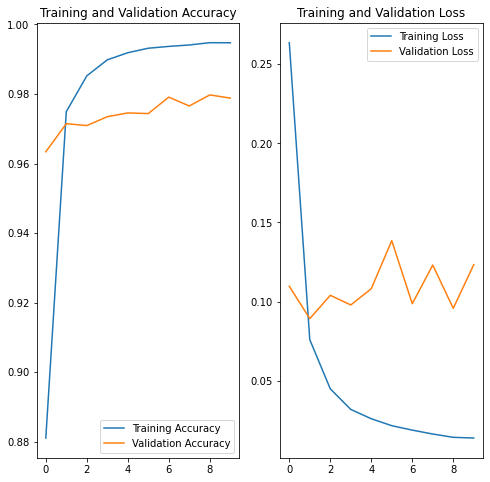

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

## Model and Tokenizer Saving

In [27]:
joblib.dump(model,'blah')
joblib.dump(tokenizer,'tok')

INFO:tensorflow:Assets written to: ram://d791d1fd-1928-4e22-bd16-1ebab4fb340b/assets


INFO:tensorflow:Assets written to: ram://d791d1fd-1928-4e22-bd16-1ebab4fb340b/assets


['tok']

## Preparing Test data

In [28]:
test=pd.read_csv('./test_tweets_anuFYb8.csv')
test

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [29]:
test_prep=test['tweet'].tolist()
test_prep

['#studiolife #aislife #requires #passion #dedication #willpower   to find #newmaterialsâ\x80¦ ',
 ' @user #white #supremacists want everyone to see the new â\x80\x98  #birdsâ\x80\x99 #movie â\x80\x94 and hereâ\x80\x99s why  ',
 'safe ways to heal your #acne!!    #altwaystoheal #healthy   #healing!! ',
 'is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ð\x9f\x98\x8dð\x9f\x98\x8dð\x9f\x98\x8d   #harrypotter #pottermore #favorite',
 '  3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ\x80¦ ',
 'choose to be   :) #momtips ',
 'something inside me dies ð\x9f\x92¦ð\x9f\x92¿â\x9c¨  eyes ness #smokeyeyes #tired  #lonely #sof #grungeâ\x80¦ ',
 '#finished#tattoo#inked#ink#loveitâ\x9d¤ï¸\x8f #â\x9d¤ï¸\x8fâ\x9d¤ï¸\x8fâ\x9d¤ï¸\x8fâ\x9d¤ï¸\x8f #thanks#aleeee !!! ',
 ' @user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels  ',
 '#delicious   #food #lovelife #capetown 

In [30]:
test_prep = tokenizer.texts_to_sequences(test_prep)
test_prep = pad_sequences(test_prep, maxlen=24)

## Model Prediction

In [31]:
model.predict(test_prep)

538/538 [==============================] - 2s 3ms/step


array([[2.9737164e-05],
       [4.8612035e-03],
       [1.9453399e-05],
       ...,
       [4.4043965e-05],
       [3.8722355e-05],
       [2.1277479e-05]], dtype=float32)

Examples on real tweets from test set:

In [36]:
example= ['loving each other every day']
example = tokenizer.texts_to_sequences(example)
example = pad_sequences(example, maxlen=75)

In [37]:
model.predict(example)

1/1 [==============================] - 0s 63ms/step


array([[3.516552e-05]], dtype=float32)

Accuracy of this example = ~0.02, that means tweet is not hate.

In [40]:
example_2=['how many more innocent people have to die while ceain politicians choose to ignore the hate and refuse to even discuss gun control']
example_2 = tokenizer.texts_to_sequences(example_2)
example_2 = pad_sequences(example_2, maxlen=75)
model.predict(example_2)

1/1 [==============================] - 0s 63ms/step


array([[1.770338e-05]], dtype=float32)

Accuracy = ~0.01. Also, this tweet is not hate.

In [41]:
example_3=['#black lives matter is a  group of #black extremist !']
example_3 = tokenizer.texts_to_sequences(example_3)
example_3 = pad_sequences(example_3, maxlen=75)
model.predict(example_3)

1/1 [==============================] - 0s 51ms/step


array([[0.9999895]], dtype=float32)

There are accuracy = ~1. It's hate speech.

#### Result of Model: The result shows the likelihood of users' tweet being related to hate speech.

## Saving the Model

In [39]:
joblib.dump(model, 'model.pkl')

INFO:tensorflow:Assets written to: ram://b56f9dfd-700b-4900-81f1-948623275978/assets


INFO:tensorflow:Assets written to: ram://b56f9dfd-700b-4900-81f1-948623275978/assets


['model.pkl']

In [44]:
model.save('./models/', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [45]:
model_loaded = tf.keras.models.load_model('./models/')